In [ ]:
!pip install -U d2l


In [ ]:
import numpy as np

In [ ]:
%matplotlib inline
import torch
from torch import nn
import torchvision
from torch.utils import data
from torchvision import datasets, transforms
from d2l import torch as d2l
import pylab
#from IPython import display

d2l.use_svg_display()

Preprocessing: Data Download and loading

In [ ]:
batch_size = 256

In [ ]:
# MNIST Dataset
train_iter = datasets.KMNIST(root='./mnist_data/',train=True,transform=transforms.ToTensor(),download=True)

test_iter = datasets.KMNIST(root='./mnist_data/',train=False,transform=transforms.ToTensor())

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_iter,batch_size=batch_size,shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_iter,batch_size=batch_size,shuffle=False)

In [ ]:
def get_kmnist_labels(labels):
  """return text labels for Fashion MNIST dataset"""
  text_labels = ['o', 'ki', 'su', 'tsu', 'na',
                 'ha', 'ma','ya', 're', 'wo']
  return [text_labels[int(i)] for i in labels]

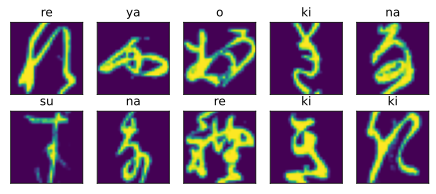

In [ ]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
  """create a function to visualize these samples"""
  figsize = (num_cols * scale, num_rows * scale)
  _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize) # return a tuple contains figure and axes
  axes = axes.flatten() # expand subplot and assign value to axes

  for i, (ax, img) in enumerate(zip(axes, imgs)):
    if torch.is_tensor(img):
      ax.imshow(img.numpy())
    else:
      ax.imshow(img)
    ax.axes.get_xaxis().set_visible(False) # hide x coordinate axis
    ax.axes.get_yaxis().set_visible(False) # hide y coordinate axis
    if titles:
      ax.set_title(titles[i])
  return axes

X, y = next(iter(data.DataLoader(train_iter, batch_size =10)))
show_images(X.reshape(10, 28, 28), 2, 5, titles = get_kmnist_labels(y));

Model

In [ ]:

net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.ReLU(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.ReLU(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120), nn.ReLU(),
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84, 10))

In [ ]:
net1 = net
net2 = net

In [ ]:
X = torch.rand(size=(1, 1, 28, 28), dtype=torch.float32)
for layer in net1:
    X = layer(X)
    print(layer.__class__.__name__,'output shape: \t',X.shape)

Conv2d output shape: 	 torch.Size([1, 6, 28, 28])
ReLU output shape: 	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape: 	 torch.Size([1, 6, 14, 14])
Conv2d output shape: 	 torch.Size([1, 16, 10, 10])
ReLU output shape: 	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape: 	 torch.Size([1, 16, 5, 5])
Flatten output shape: 	 torch.Size([1, 400])
Linear output shape: 	 torch.Size([1, 120])
ReLU output shape: 	 torch.Size([1, 120])
Linear output shape: 	 torch.Size([1, 84])
Sigmoid output shape: 	 torch.Size([1, 84])
Linear output shape: 	 torch.Size([1, 10])


GPU Accuracy Evaluation

In [ ]:
def evaluate_accuracy_gpu(net, data_iter, device=None): #save
    """Compute the accuracy for a model on a dataset using a GPU."""
    if isinstance(net, nn.Module):
        net.eval()  # Set the model to evaluation mode
        if not device:
            device = next(iter(net.parameters())).device
    # No. of correct predictions, no. of predictions
    metric = d2l.Accumulator(2)

    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # Required for BERT Fine-tuning (to be covered later)
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

Training (with loss function: cross entropy)

In [ ]:
def train_ch6_CE(net, train_iter, test_iter, num_epochs, lr, device):#save
    """Train a model with a GPU (defined in Chapter 6)."""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # Sum of training loss, sum of training accuracy, no. of examples
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

Training (with a different loss function: multi margin loss)

In [ ]:
def train_ch6_MML(net, train_iter, test_iter, num_epochs, lr, device):#save
    """Train a model with a GPU (defined in Chapter 6)."""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.MultiMarginLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # Sum of training loss, sum of training accuracy, no. of examples
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

(1) Original graph

loss 0.094, train acc 0.973, test acc 0.913
3994.8 examples/sec on cpu


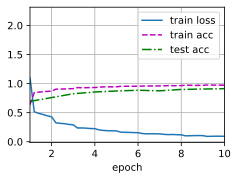

In [ ]:
lr, num_epochs = 0.1, 10
train_ch6_CE(net1, train_loader, test_loader, num_epochs, lr, d2l.try_gpu())

(2) using a different loss function: multi margin loss

loss 0.021, train acc 0.950, test acc 0.878
4819.1 examples/sec on cpu


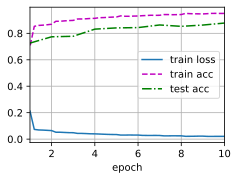

In [ ]:
lr, num_epochs = 0.1, 10
train_ch6_MML(net2, train_loader, test_loader, num_epochs, lr, d2l.try_gpu())

(3) Different learning rate from different loss function

loss 1.724, train acc 0.549, test acc 0.448
15753.6 examples/sec on cuda:0


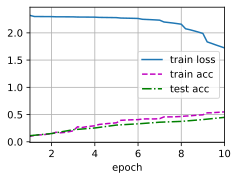

In [ ]:
#loss function: cross entropy
lr, num_epochs = 0.001, 10
train_ch6_CE(net1, train_loader, test_loader, num_epochs, lr, d2l.try_gpu())

loss 0.389, train acc 0.576, test acc 0.439
4679.1 examples/sec on cpu


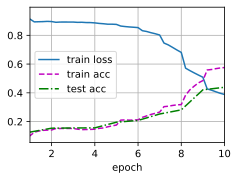

In [ ]:
#loss function: multi margin funcation
lr, num_epochs = 0.001, 10
train_ch6_MML(net2, train_loader, test_loader, num_epochs, lr, d2l.try_gpu())

(4) Different batch size (32) from different loss function

loss 0.165, train acc 0.953, test acc 0.883
66846.6 examples/sec on cuda:0


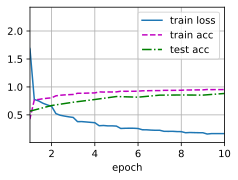

In [ ]:
#loss function: cross entropy
lr, num_epochs = 0.1, 10
train_ch6_CE(net1, train_loader, test_loader, num_epochs, lr, d2l.try_gpu())

loss 0.045, train acc 0.905, test acc 0.791
5060.8 examples/sec on cpu


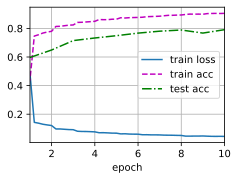

In [ ]:
#loss function: multi margin loss
lr, num_epochs = 0.1, 10
train_ch6_MML(net2, train_loader, test_loader, num_epochs, lr, d2l.try_gpu())

(5) Images visualization

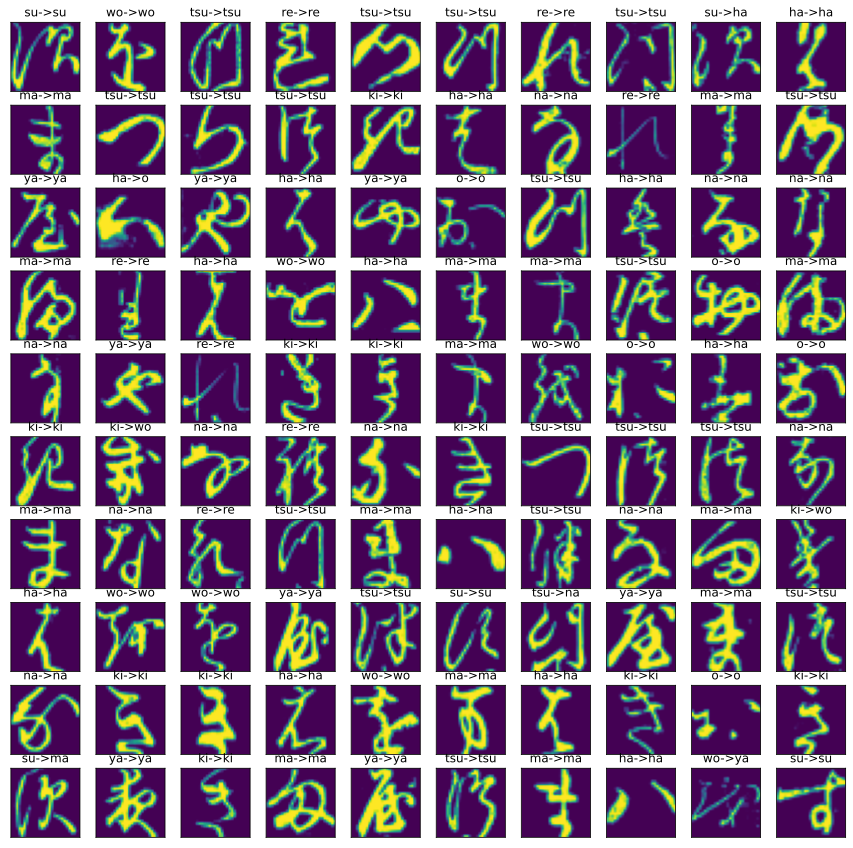

In [ ]:
def predict_ch3(net, test_iter, n=100):
  for X, y in test_iter:
    break
  trues = get_kmnist_labels(y)
  preds = get_kmnist_labels(net(X).argmax(axis=1))
  titles = [true +'->' +pred for true, pred in zip(trues, preds)]
  d2l.show_images(
    X[0:n].reshape((n, 28, 28)), 10, 10, titles=titles[0:n])
  pylab.show()

test=test_loader
predict_ch3(net1, test)